<a href="https://colab.research.google.com/github/luke-nikolic/Bank-Data_Set_Analysis/blob/main/Bank_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction 

This is a simple project that broadly aims to find which features, out of the full bank data set from the UCI repository, are most significant for the model predictions of two classical machine learning models - neural network (Keras Sequential API), and random forests ensemble. 

The data that was used for this project is related to the marketing campaigns (phone calls) of a Portuguese banking institution from May 2008 to November 2010. The data consisted of 41,188 observations of different prospective clients who were measured on 21 different features related to them. The full details for this data set can be found here https://archive.ics.uci.edu/ml/datasets/bank+marketing


Project begins with some exploratory data analysis, then moves to model building and prediction, and finishes with some model comparison and sensitivty analysis using SHAP values. 

In [1]:
# Import useful packages

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

In [2]:
# Upload data set so it can be read in as csv file 

from google.colab import files

uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [3]:
# Read in csv file

df = pd.read_csv("bank-additional-full.csv", header=0, sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Check for missing values

df.info() # Shows there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df.describe() # Overview for numeric columns. Can see that the data has not been normalised

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# Looking at statistics for non-numeric features

df.describe(include = ["object"])

# Can see that the average observation is someone who is part of the adminstrative staff,
# is married, and has a university education



,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [7]:
# Show fequencies of these values

df["marital"].value_counts(normalize = True), df["education"].value_counts(normalize = True), df["job"].value_counts(normalize = True)

(married     0.605225
 single      0.280859
 divorced    0.111974
 unknown     0.001942
 Name: marital, dtype: float64, university.degree      0.295426
 high.school            0.231014
 basic.9y               0.146766
 professional.course    0.127294
 basic.4y               0.101389
 basic.6y               0.055647
 unknown                0.042027
 illiterate             0.000437
 Name: education, dtype: float64, admin.           0.253035
 blue-collar      0.224677
 technician       0.163713
 services         0.096363
 management       0.070992
 retired          0.041760
 entrepreneur     0.035350
 self-employed    0.034500
 housemaid        0.025736
 unemployed       0.024619
 student          0.021244
 unknown          0.008012
 Name: job, dtype: float64)

In [8]:
df.sort_values(by = ["age", "duration"], ascending = [True, False]).head()

# Can see that the youngest customers are at the age of 17, 
# and the call duration exceeded 3 minutes only for three clients, 
# which indicates the ineffectiveness of long-term interaction with such clients.

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
38274,17,student,single,unknown,no,no,yes,cellular,oct,tue,...,1,2,2,success,-3.4,92.431,-26.9,0.742,5017.5,yes
37579,17,student,single,basic.9y,no,unknown,unknown,cellular,aug,fri,...,2,999,1,failure,-2.9,92.201,-31.4,0.869,5076.2,yes
37140,17,student,single,unknown,no,yes,no,cellular,aug,wed,...,3,4,2,success,-2.9,92.201,-31.4,0.884,5076.2,no
37539,17,student,single,basic.9y,no,yes,no,cellular,aug,fri,...,2,999,2,failure,-2.9,92.201,-31.4,0.869,5076.2,no
37558,17,student,single,basic.9y,no,yes,no,cellular,aug,fri,...,3,4,2,success,-2.9,92.201,-31.4,0.869,5076.2,no


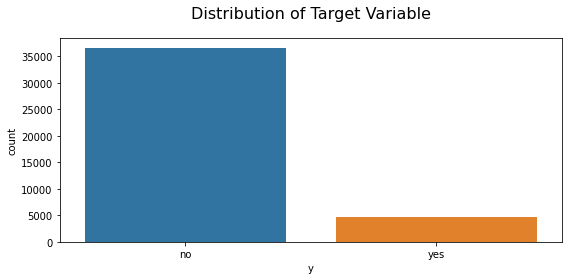

In [9]:
# Checking distribution of target variable

fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x=df['y'], ax=ax)

abs_vals = df['y'].value_counts()
rel_vals = df['y'].value_counts(normalize=True) * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_vals, rel_vals)]

#ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Distribution of Target Variable', fontsize=16, pad=20)

plt.tight_layout();

# Can see that distribution of target variable is highly skewed towards "no" 
# response. Could be early indication that our model will have more false 
# positives than false negatives as it will have less "positive" data to train 
# on. 

In [10]:
# Changing target variable to binary but not one-hot encoding categorical variables yet


df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


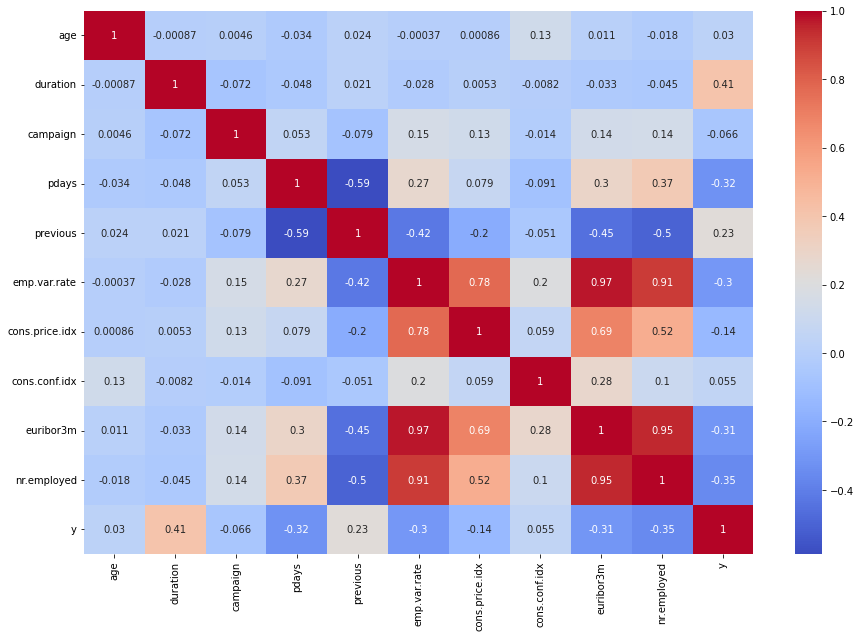

In [12]:
# Correlation matrix to identify any strong correlations between variables
plt.figure(figsize=(15,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Correlation matrix shows that there are not any particularly strong correlations
# between features and the target variable "y". However, there are some features
# which are extremely highly correlated. For example euribor3m and emp.var.rate 
# (0.97), nr.employed and emp.var.rate (0.91), and euribor3m and nr.employed 
# (0.95). 

# Presence of highly correlated features can sometimes be problematic when 
# building neural network, hence will include regularisation to counter this

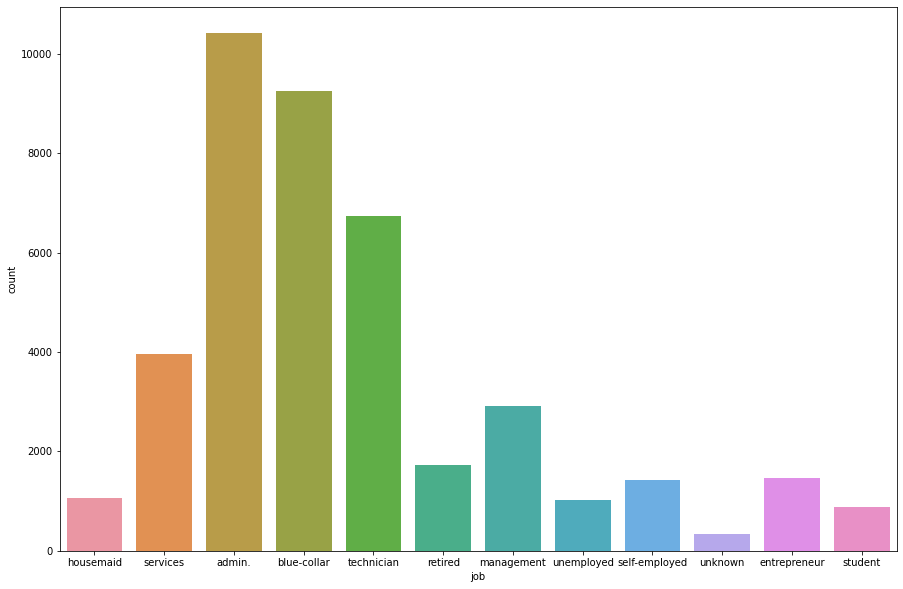

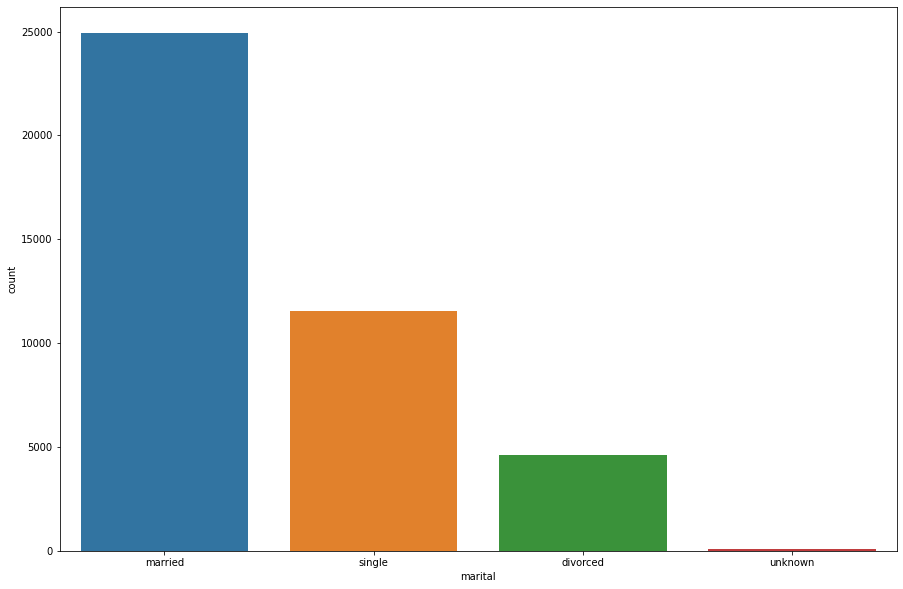

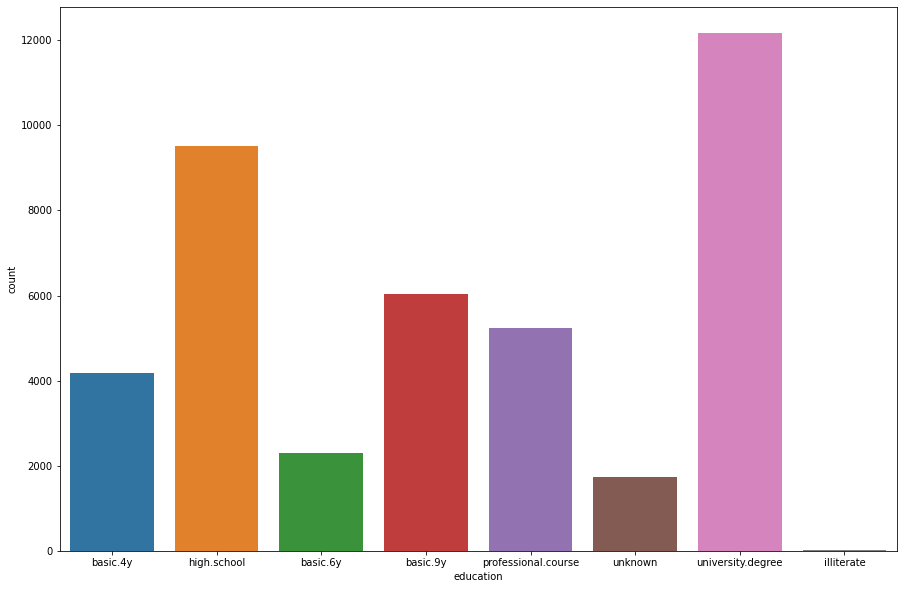

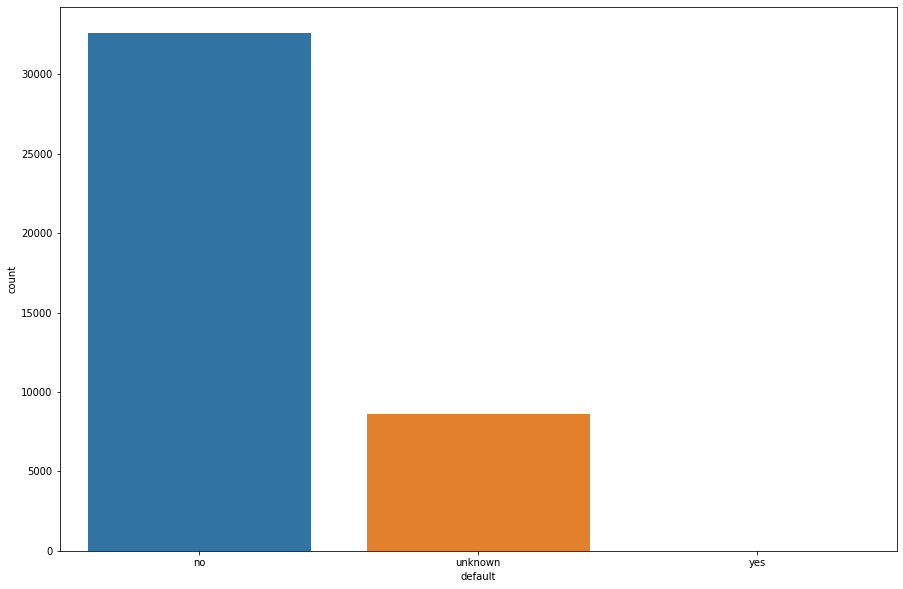

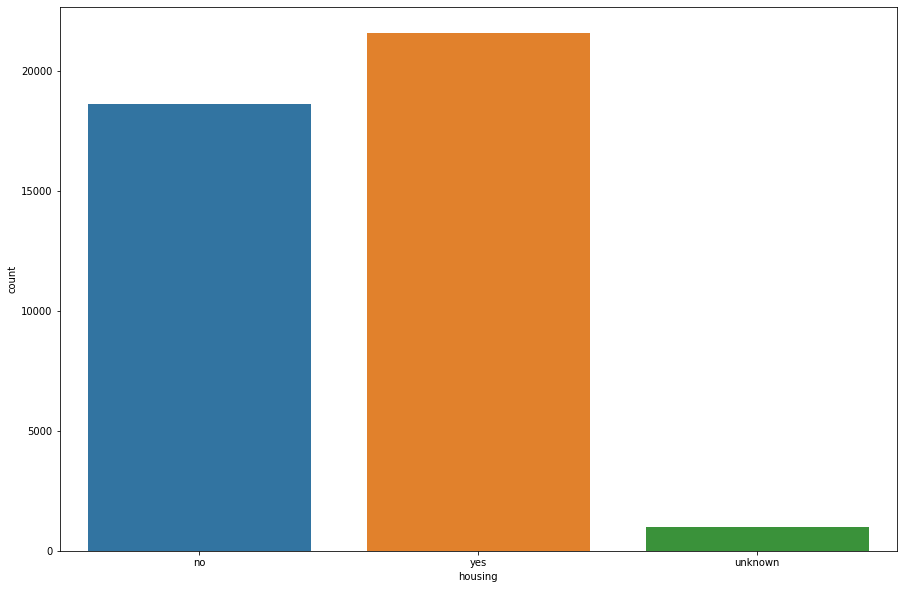

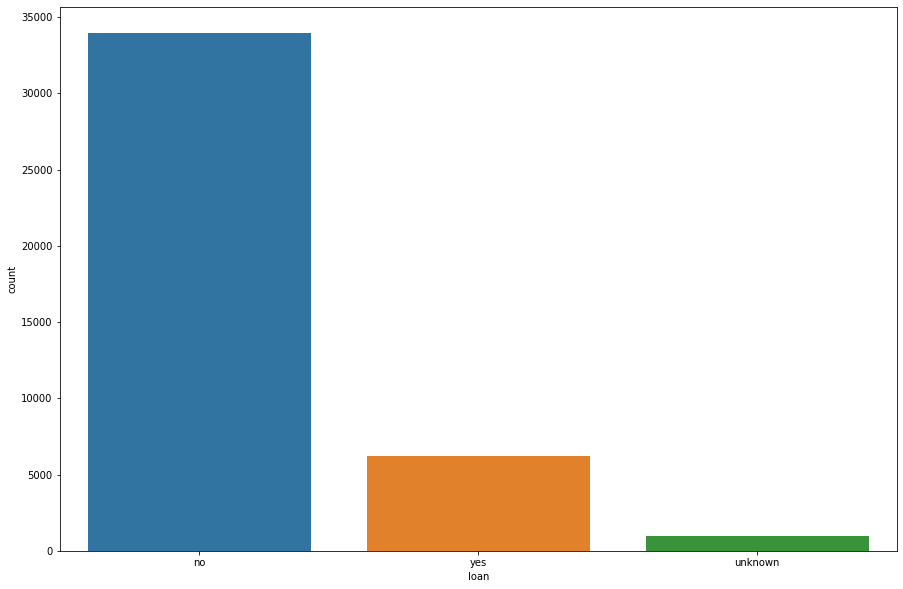

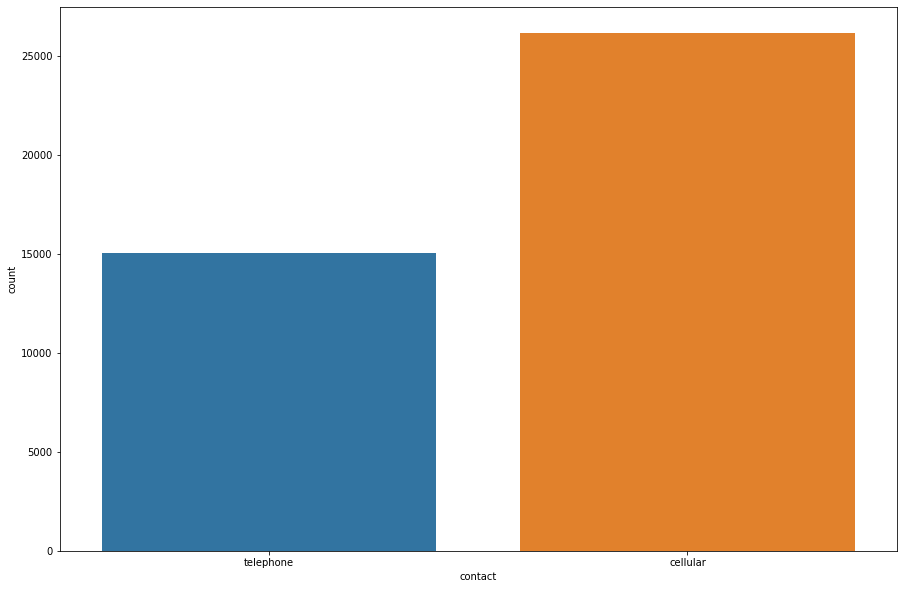

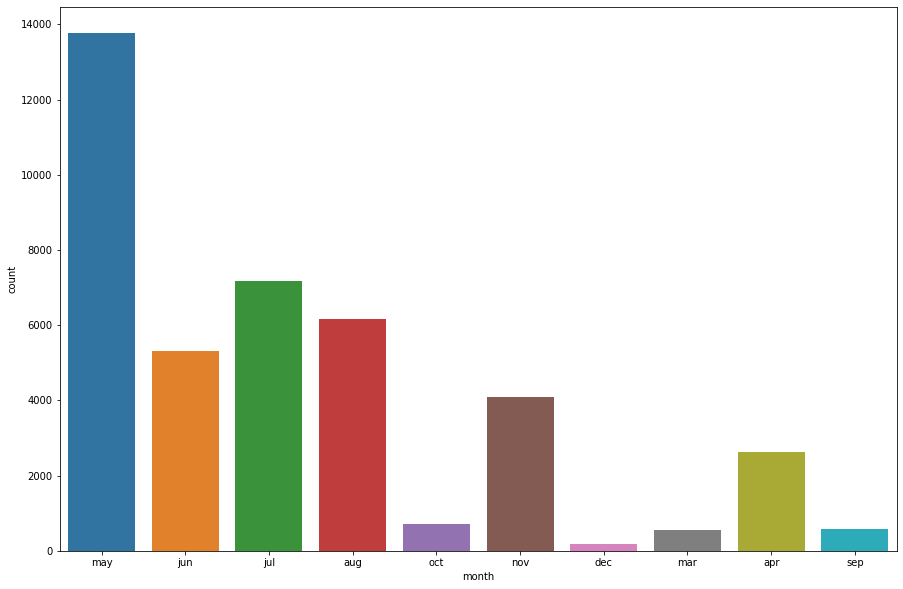

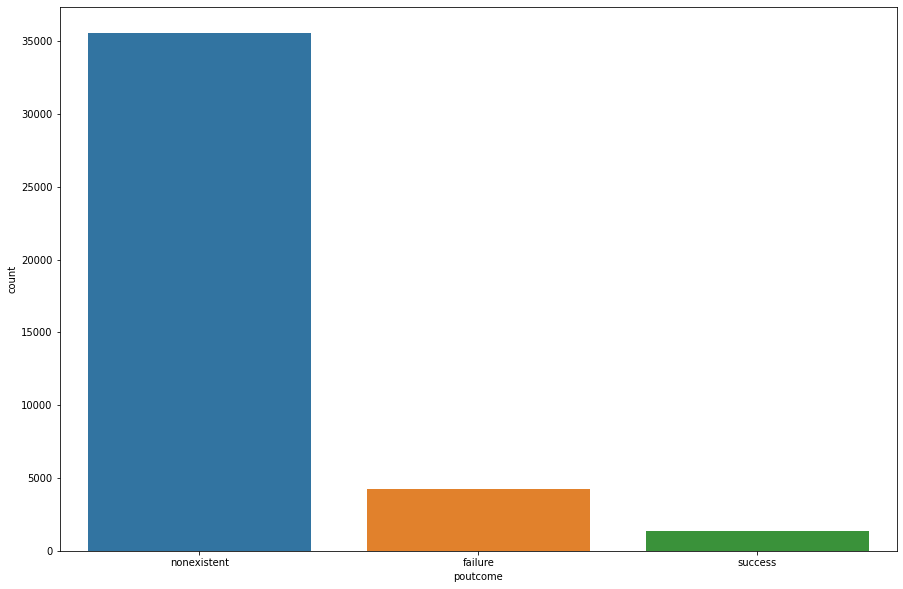

In [18]:
# Bar graphs to show variability of categorical data

columns_to_plot = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for i in columns_to_plot:
  plt.figure(figsize=(15,10))
  sns.countplot(x=i, data = df)
  plt.show()

In [19]:
# In order to determine correlations for categorical variables, compute 
# cramers V statistic between categorical variables and binary target 
# value. Using Cramer's V statistic since the categorical variables in this 
# data set have more than two unique values. 


from scipy.stats import chi2_contingency

# Create a contingency table for each categorical variable and the response variable
for col in df.select_dtypes(include='object'):
    cont_table = pd.crosstab(df[col], df['y'])
    
    # Compute the chi-squared statistic and p-value
    chi2, p, dof, expected = chi2_contingency(cont_table)
    
    # Compute the Cramer's V coefficient
    n = cont_table.sum().sum()
    phi = np.sqrt(chi2 / n)
    k = min(cont_table.shape[0], cont_table.shape[1])
    v = np.sqrt(phi / (k - 1))
    
    # Print the results
    print(f'{col}: V = {v:.3f}, p = {p:.3f}')



# Results show that none of the categorical variables have a particularly
# high correlation with the target variable 'y'. 

job: V = 0.391, p = 0.000
marital: V = 0.234, p = 0.000
education: V = 0.262, p = 0.000
default: V = 0.315, p = 0.000
housing: V = 0.108, p = 0.058
loan: V = 0.072, p = 0.579
contact: V = 0.380, p = 0.000
month: V = 0.524, p = 0.000
day_of_week: V = 0.159, p = 0.000
poutcome: V = 0.566, p = 0.000


In [20]:
# Code for determining the pairwise correlations between the 
# categorical variables (computing Cramer's V statistic again)


# Select the categorical variables
cat_vars = df.select_dtypes(include='object')

# Create an empty dataframe to store the correlation coefficients
corr_df = pd.DataFrame(index=cat_vars.columns, columns=cat_vars.columns)

# Iterate over each pair of variables
for i, var1 in enumerate(cat_vars):
    for j, var2 in enumerate(cat_vars):
        if i >= j:
            continue
        
        # Create the contingency table
        cont_table = pd.crosstab(df[var1], df[var2])
        
        # Compute the Cramer's V statistic
        chi2, p, dof, expected = chi2_contingency(cont_table)
        n = cont_table.values.sum()
        v = np.sqrt(chi2 / (n * (min(cont_table.shape) - 1)))
        
        # Store the correlation coefficient in the dataframe
        corr_df.loc[var1, var2] = v
        corr_df.loc[var2, var1] = v

# Print the correlation coefficients
print(corr_df)

# None of the categorical variables seem to have a 
# particularly strong association with each other. 


                  job   marital education   default   housing      loan  \
job               NaN   0.18431  0.359867  0.152973  0.019496  0.019274   
marital       0.18431       NaN  0.116964  0.095813  0.012527  0.006356   
education    0.359867  0.116964       NaN  0.170849  0.018635  0.013012   
default      0.152973  0.095813  0.170849       NaN  0.012663  0.007142   
housing      0.019496  0.012527  0.018635  0.012663       NaN   0.70787   
loan         0.019274  0.006356  0.013012  0.007142   0.70787       NaN   
contact      0.128894  0.072497  0.123988  0.135731  0.084889  0.025189   
month        0.111032  0.052304  0.095856  0.112895   0.05622  0.024733   
day_of_week  0.023193  0.014685  0.023643  0.015004  0.017643  0.011592   
poutcome      0.10089  0.037611  0.044245  0.076943  0.018333  0.004404   

              contact     month day_of_week  poutcome  
job          0.128894  0.111032    0.023193   0.10089  
marital      0.072497  0.052304    0.014685  0.037611  
educat

In [21]:
# one hot encode categorical variables

bank_data = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 
                                               'housing', 'loan', 'contact', 'month', 'day_of_week', 
                                               'poutcome'])

In [22]:
print("Share of attracted clients =", '{:.1%}'.format(bank_data["y"].mean()))

# Can see that percentage of clients attracted for this business is very low. 
# This is bad indication for a bank. 


Share of attracted clients = 11.3%


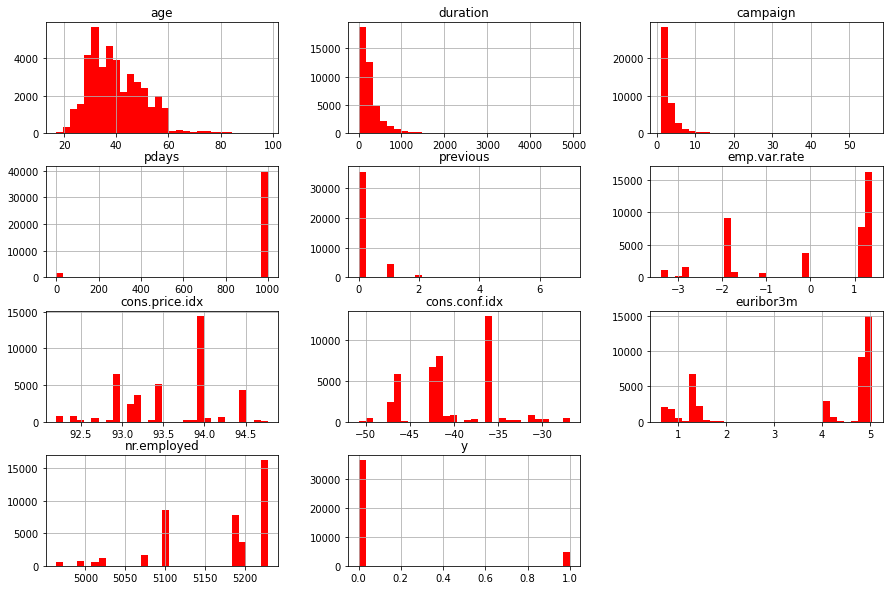

In [23]:
# Building histograms for all the numerical features

df.hist(color = "r",
        bins = 30,
        figsize = (15, 10))
plt.show()

# Can see that majority of ages range from 25-50, which corresponds to good part of 
# working population. 



## Data Preprocessing

In [24]:
# Split data into training and test sets

tf.random.set_seed(42)

X = bank_data.drop('y', axis=1)
y = bank_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Since we have large data set, splitting data such that 75% is training data and 25%
# is test data

# Before proceeding with analysis will normalise the data too

scalar = StandardScaler()

# Fit scalar to training data

scalar.fit(X_train)

# Transform the test data and training data using the scalar
# Note that it is important to fit the scaler to the training data only and then use the same scaler to transform the test data. 
# This is because the test data represents new, unseen data that the model will be evaluated on, 
# and should be transformed in the same way as the training data. 


X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)



## Modelling 

Initially I fitted the model for 100 epochs, but since I did not see much change 
in the validation accuracy during the later stages of training, I added the EarlyStopping callback to the fit method. 
I have set ```monitor='val_accuracy'``` to monitor the validation accuracy, and patience=10 to wait 
for 10 epochs before stopping training if the validation accuracy does not improve. 

I also set the correlation coefficient for the l2 regularisation term to be 0.01 which I found to work well after some experimentation. 


In [25]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

# Build the model with L2 regularization
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1], ), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/100
773/773 [==============================] - 10s 5ms/step - loss: 0.5242 - accuracy: 0.9042 - val_loss: 0.2636 - val_accuracy: 0.9087
Epoch 2/100
773/773 [==============================] - 5s 6ms/step - loss: 0.2386 - accuracy: 0.9095 - val_loss: 0.2331 - val_accuracy: 0.9086
Epoch 3/100
773/773 [==============================] - 4s 5ms/step - loss: 0.2262 - accuracy: 0.9095 - val_loss: 0.2310 - val_accuracy: 0.9074
Epoch 4/100
773/773 [==============================] - 3s 4ms/step - loss: 0.2225 - accuracy: 0.9119 - val_loss: 0.2252 - val_accuracy: 0.9089
Epoch 5/100
773/773 [==============================] - 3s 4ms/step - loss: 0.2201 - accuracy: 0.9102 - val_loss: 0.2234 - val_accuracy: 0.9079
Epoch 6/100
773/773 [==============================] - 5s 6ms/step - loss: 0.2174 - accuracy: 0.9106 - val_loss: 0.2237 - val_accuracy: 0.9084
Epoch 7/100
773/773 [==============================] - 4s 6ms/step - loss: 0.2157 - accuracy: 0.9098 - val_loss: 0.2203 - val_accuracy: 0.910

Text(0.5, 1.0, 'Model loss curves')

<Figure size 1080x720 with 0 Axes>

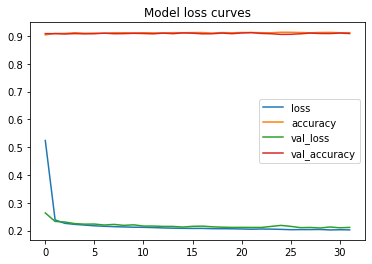

In [31]:
# Plot loss curves to show model's performance

plt.figure(figsize=(15,10))
pd.DataFrame(history.history).plot()
plt.title("Model loss curves")

Model training appears to be stable and seems to have only trained for 30 out of the 100 epochs due to our early stopping callback. Model also seems to have finished on a high validation accuracy of ~90% and low validation loss of ~0.2

In [ ]:
# Provide summary of model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4096      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Evaluating the model

# Model predictions
y_probs = model.predict(X_test)
# Convert all of the prediction probabilities into 
# integers so now they're in same form as labels

y_preds = (y_probs > 0.5).astype(int) # Converts all probabilities to binary predictions

# Since the model outputs probabilities, we need to convert these to binary predictions by setting a threshold of 0.5, 
# above which we classify an example as belonging to the positive class, 
# and below which we classify it as belonging to the negative class.




322/322 [==============================] - 1s 2ms/step


In [28]:
# Produce Classification Report
from sklearn.metrics import classification_report

y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype(int)
target_names = ["Client did not subscribe (class 0)", "Client subscribed (class 1)"]

report_dict = classification_report(y_test, y_preds,
                                    target_names = target_names,
                                    output_dict = True)
df_report = pd.DataFrame(report_dict).transpose()
df_report

322/322 [==============================] - 1s 3ms/step


,precision,recall,f1-score,support
Client did not subscribe (class 0),0.950500,0.955490,0.952989,9144.000000
Client subscribed (class 1),0.631674,0.605377,0.618246,1153.000000
accuracy,0.916286,0.916286,0.916286,0.916286
macro avg,0.791087,0.780434,0.785617,10297.000000
weighted avg,0.914800,0.916286,0.915506,10297.000000


The classification report demonstrates that my model has a good overall accuracy of ~91%, meaning that it correctly predicted the class for ~91% of the cases. The report also suggests that the model performs well for the ”Client did not subscribe” class (class 0) with high precision, recall and F1 scores of roughly 95%. However, the model performs sub-optimally for the ”Client subscribed” class (class 1), with a precision score of 0.63. This means that only 63% of the predicted positive instances (i.e., ”Client subscribed” cases) are actually positive. Moreover, it has a recall score of only 0.61, meaning that it only correctly identifies ~61% of the cases that are of class 1. This result is perhaps not surprising however, since as highlighted in my exploratory data analysis there are far fewer positive samples in the overall data set than negative ones.

<AxesSubplot:>

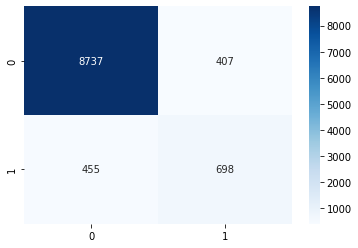

In [29]:
# Produce confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")

The confusion matrix also corroborates some of the findings highlighted in the classification report. Specifically, it shows that out of all cases that were of class 0, it correctly predicted ~95% of them. Moreover it demonstrates that out of all the cases that were of class 1, my model only correctly predicted about ~61% of them, echoing the recall score of 0.61 given for the positive class in the classification report.


In [33]:
# Building random forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Set a seed for reproducibility
tf.random.set_seed(42)

# Create an ensemble of decision trees with random forests
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_preds_rf = clf.predict(X_test)
accur_rf = accuracy_score(y_test, y_preds_rf)

print(f"Accuracy score for random forests: {accur_rf:.4f}")

Accuracy score for random forests: 0.9126


Random forest classifier initially appears to do better than neural net, however will produce classification report to investigate the results of the modelling more thoroughly

In [35]:
# Produce classification report for random forest classifier
from sklearn.metrics import classification_report

target_names = ["Client did not subscribe (class 0)", "Client subscribed (class 1)"]
report_dict_f = classification_report(y_test, y_preds_rf,
                                    target_names = target_names,
                                    output_dict = True)
df_report_f = pd.DataFrame(report_dict_f).transpose()
df_report_f

,precision,recall,f1-score,support
Client did not subscribe (class 0),0.933712,0.970472,0.951737,9144.000000
Client subscribed (class 1),0.659521,0.453599,0.537513,1153.000000
accuracy,0.912596,0.912596,0.912596,0.912596
macro avg,0.796616,0.712036,0.744625,10297.000000
weighted avg,0.903010,0.912596,0.905355,10297.000000


The report also shows that the model performs well for class 0, with high precision, recall , and f1-scores. However, it has poor precision and recall scores of 0.66 and 0.45 respectively. These scores indicate that ~66% of the predicted class 1 instances are actually of this class, and that it only correctly identifies ~45% of the cases that are of class 1. 

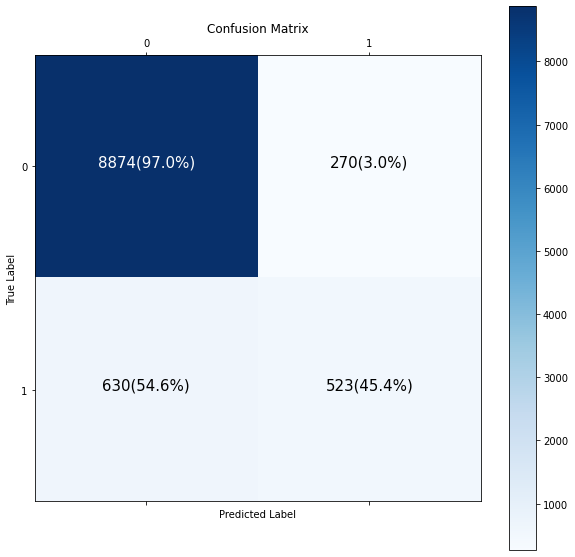

In [36]:
# Produce pretty confusion matrix for random forest classifier

import itertools
from sklearn.metrics import confusion_matrix

figsize = (10,10)

# Create the confusion matrix

cm = confusion_matrix(y_test, y_preds_rf)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:,np.newaxis] # normalize our confusion matrix
n_classes = cm.shape[0]
# Let's prettify it 

fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot 
cax = ax.matshow(cm,cmap = plt.cm.Blues)
fig.colorbar(cax)

# Create classes 
classes = False 

if classes:
  labels = classes 
else:
  labels = np.arange(cm.shape[0])

# Label the axes

ax.set(title = "Confusion Matrix",
       xlabel = "Predicted Label",
       ylabel = "True Label",
       xticks = np.arange(n_classes),
       yticks = np.arange(n_classes),
       xticklabels = labels,
       yticklabels = labels)

# Set threshold for different colors

threshold = (cm.max() + cm.min()) / 2

# Plot the text onn each cell 

for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j,i,f"{cm[i,j]}({cm_norm[i,j]*100:.1f}%)",
           horizontalalignment = "center",
           color = "white" if cm[i,j] > threshold else "black",
           size = 15)

The confusion matrix supports results found from the classification report, showing that out of all of the cases that were of class 0, the model correctly predicted 97% of these cases, and that out of all the cases that were of class 1, the model only correctly predicted 45.4% of these cases. 

Therefore whilst my random forest classifier has higher overall accuracy, it performs worse for the positive class. Since the discrepancy in overall accuracy between the models is only ~1%, it might be suggested that the neural network is the more desirable model since it performs significantly better (by ~15%) for the positive class. 

## Sensitivity Analysis (SHAP values)

In [38]:
# Install SHAP package
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 20.3 MB/s eta 0:00:00


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


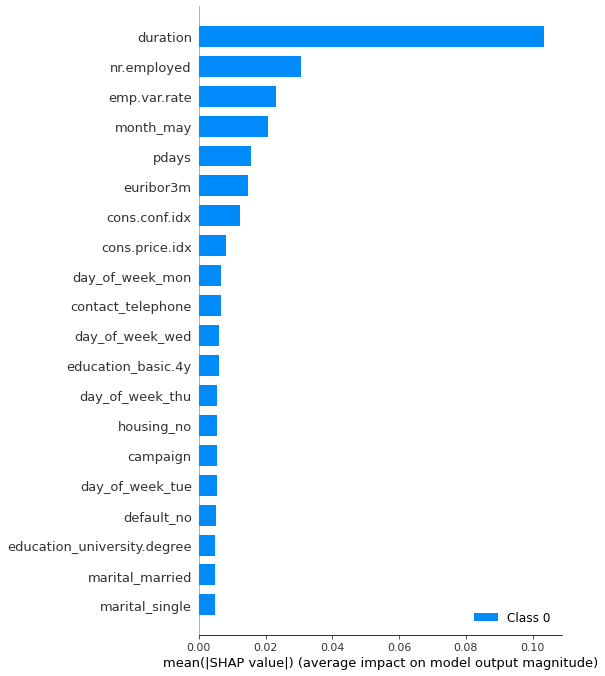

In [39]:
# Compute SHAP values for neural network and produce summary plot 

import shap
features = X.columns
features_list = features.tolist()
shap.initjs()
# Load the SHAP explainer using DeepExplainer
explainer = shap.DeepExplainer(model, X_test)

# Compute SHAP values for a subset of validation data
shap_values = explainer.shap_values(X_test[:1000])

# Plot the variable importance
shap.summary_plot(shap_values, X_test, feature_names = features_list,plot_type="bar")

Variable importance plot shows that duration, nr.employed, and 
emp.var.rate seem to be most significant variables for model 
output

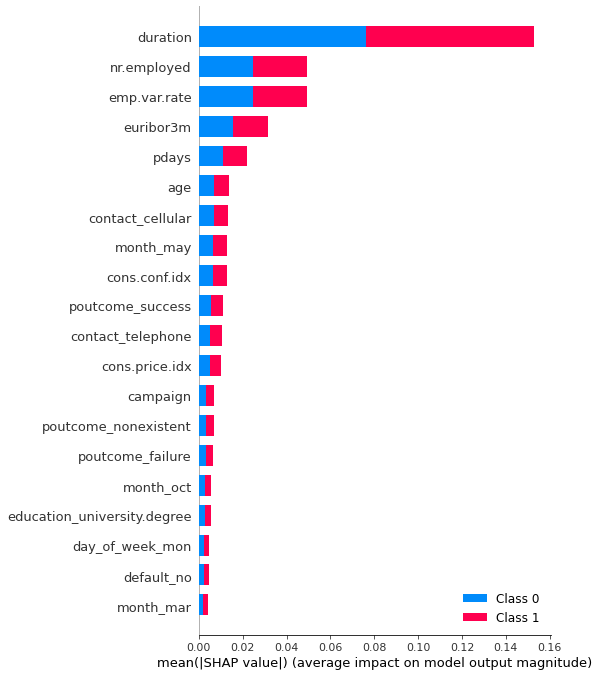

In [40]:
# Compute SHAP values for random forest classifier for same subset of data
shap.initjs()

# Load SHAP explainer using TreeExplainer since dealing with random forest classifier
explainer = shap.TreeExplainer(clf)

# Compute SHAP values for subset of validation data (same as for neural net)
shap_values = explainer.shap_values(X_test[:1000])

# Plot the variable importance
shap.summary_plot(shap_values,X_test,feature_names=features_list)

Can see that variables deemed most significant are the same - duration, nr.emplyed, and emp.var.rate